# DATA 512, A1: Data curation

In [228]:
import pandas as pd
import numpy as np
%matplotlib inline 
# TODO is the %matplotlib recommended or old?

import requests
import os
import json

## Page counts
- 1/1/2008 to 7/31/2016 per the assignment wiki page (although 8/1/2008 to 7/31/2016 per class slides)
- 'desktop-site' can also be 'mobile-site'

URL 
https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/en.wikipedia.org/desktop-site/monthly/2008010100/2008040100

API docs w/ URL
https://wikimedia.org/api/rest_v1/#!/Pagecounts_data_(legacy)/get_metrics_legacy_pagecounts_aggregate_project_access_site_granularity_start_end

## Page views
- 7/1/2015 to present per class slides
- 'desktop' can also be 'mobile-app' or 'mobile-web'
- 'user' says we do not want spider/crawler views

URL https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia.org/desktop/user/monthly/2015070100/2017100100

API docs w/ URL https://wikimedia.org/api/rest_v1/#!/Pageviews_data/get_metrics_pageviews_aggregate_project_access_agent_granularity_start_end

**TODO** make sure to explain why we're setting the API params as we do in the hardcode URL and changeable stuff below, since we refer to here.

**TODO** note that real reproducibility needs tests for the code - i'd normally put the functions i define below in a separate file that I import here, and then test them from that separate file. for this one i'll just keep everything in this file for simplicity even though it means i can't test them the way i normally would.

In [2]:
endpoint = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

headers={'User-Agent' : 'https://github.com/your_github_username', 'From' : 'your_uw_email@uw.edu'}

params = {'project' : 'en.wikipedia.org',
            'access' : 'mobile-web',
            'agent' : 'spider',
            'granularity' : 'monthly',
            'start' : '2017090100',
            'end' : '2017101000'#use the first day of the following month to ensure a full month of data is collected
            }

api_call = requests.get(endpoint.format(**params), headers=headers)
response = api_call.json()
print(response)

{'items': [{'project': 'en.wikipedia', 'access': 'mobile-web', 'agent': 'spider', 'granularity': 'monthly', 'timestamp': '2017090100', 'views': 69790930}]}


In [51]:
foodate = "2015070100"
foodate[:6]

'201507'

In [91]:
PAGECOUNTS_START = '2008010100'
PAGECOUNTS_END = '2016073100'
PAGEVIEWS_START = '2015070100'
PAGEVIEWS_END = '2017093000'
# note that passing the exact ending day of the last month, as above, causes the API to return 
# the same same result as passing a day in the following month; passing the ending day
# also simplifies the filename generation code because it doesn't need to 'go back'

USER_AGENT = 'https://github.com/aenfield'

In [92]:
def get_param_dict_from_params(access, start, end):
    """Convenience function to get a params dict given the passed values."""
    return {'access': access, 'start': start, 'end': end}

In [130]:
def get_filename_from_params(apiname, params):
    """TODO docs. include that because of the practice of passing a """
    
    # Mark up the dict so we can pass a dict with all values we need.
    # We have to format the start/end because .format doesn't handle
    # string slicing in the format string itself. We'll use a copy
    # so we don't modify the passed dict as an undesirable side effect.
    p = params.copy()
    p['apiname'] = apiname 
    p['start'] = p['start'][:6] # we only want year/month - could convert to datetime and format but this is simpler given that we know the input format
    p['end'] = p['end'][:6]
    return "{apiname}_{access}_{start}_{end}.json".format(**p)

In [131]:
get_filename_from_params('pageviews', get_param_dict_from_params('mobile_app', PAGEVIEWS_START, PAGEVIEWS_END))

'pageviews_mobile_app_201507_201709.json'

In [198]:
def download_page_access_data(apiname, params, user_agent, force=False, verbose=False):
    """TODO add docs, including the allowed values for access per a given endpoint, 
    and that behavior is to just pass through failure if something incorrect is passed, and that
    this saves the data as files if they don't already exist/haven't been downloaded yet"""
    # TODO incorp these notes into the genearl or param docs
    # Define endpoint URLs to include/hardcode the params we don't need to vary, per the above text. 
    # Also, for ease in calling the function, I'm b clarity and since only access/access-site needs to change per request, I've promoted 
    # this to a specifically  named function parameter, which I'll consistently call 'access'. Finally, 
    # since the API doc says only 'User-Agent' is required (not 'From'), I'll also promote this to 
    # a function parameter. we need to pass more than we would as params so we have the data easily 
    # to use when checking for/writing files
    
    filename = get_filename_from_params(apiname, params)
    if verbose: print("Using filename: {}.".format(filename)) 
    
    if (not os.path.exists(filename)) | (force == True):
        if (apiname == 'pagecounts'):
            endpoint_template = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/en.wikipedia.org/{access}/monthly/{start}/{end}'
        elif (apiname == 'pageviews'):
            endpoint_template = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia.org/{access}/user/monthly/{start}/{end}'
        # note that I'm not checking for valid apiname values - per what I understand
        # standard Python practice to be, it's the caller's responsibility to pass
        # correct values - here if they don't, the REST request will fail

        url = endpoint_template.format(**params)
        if verbose: print("Retrieving {} .".format(url))
        response = requests.get(url, headers = {'User-Agent':'{}'.format(user_agent)})
        with open(filename, 'w') as file:
            file.write(response.text) # requests doesn't have a method to download and write at the same time, like urllib, so we write here (urllib doesn't easily enable user agent setting, so we don't use it)
            
    if verbose: print("Complete.")

In [199]:
download_page_access_data('pageviews', 
                     get_param_dict_from_params('desktop', PAGEVIEWS_START, PAGEVIEWS_END), 
                     USER_AGENT, force=True, verbose=True)

Using filename: pageviews_desktop_201507_201709.json.
Retrieving https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia.org/desktop/user/monthly/2015070100/2017093000 .
Complete.


In [217]:
f = get_filename_from_params('pageviews', get_param_dict_from_params('desktop', PAGEVIEWS_START, PAGEVIEWS_END))
with open(f) as json_data:
    d_as_json = json.load(json_data)
    
# pandas read_json needs the data as a string (not parsed JSON) and without the 
# 'items' preface that the API returns; we can't let read_json convert dates because it 
# doesn't handle this format ok - we'll convert next
d = pd.read_json(json.dumps(d_as_json['items']), orient='records', convert_dates=False)
d[:5]

,access,agent,granularity,project,timestamp,views
0,desktop,user,monthly,en.wikipedia,2015070100,4376666686
1,desktop,user,monthly,en.wikipedia,2015080100,4332482183
2,desktop,user,monthly,en.wikipedia,2015090100,4485491704
3,desktop,user,monthly,en.wikipedia,2015100100,4477532755
4,desktop,user,monthly,en.wikipedia,2015110100,4287720220


In [220]:
d['timestamp'] = pd.to_datetime(d['timestamp'], format='%Y%m%d%H')

In [221]:
d.dtypes             

access                 object
agent                  object
granularity            object
project                object
timestamp      datetime64[ns]
views                   int64
dtype: object

In [222]:
d[:5]

,access,agent,granularity,project,timestamp,views
0,desktop,user,monthly,en.wikipedia,2015-07-01,4376666686
1,desktop,user,monthly,en.wikipedia,2015-08-01,4332482183
2,desktop,user,monthly,en.wikipedia,2015-09-01,4485491704
3,desktop,user,monthly,en.wikipedia,2015-10-01,4477532755
4,desktop,user,monthly,en.wikipedia,2015-11-01,4287720220


In [223]:
d.set_index('timestamp', inplace=True)
d[:5]

,access,agent,granularity,project,views
timestamp,,,,,
2015-07-01,desktop,user,monthly,en.wikipedia,4376666686
2015-08-01,desktop,user,monthly,en.wikipedia,4332482183
2015-09-01,desktop,user,monthly,en.wikipedia,4485491704
2015-10-01,desktop,user,monthly,en.wikipedia,4477532755
2015-11-01,desktop,user,monthly,en.wikipedia,4287720220


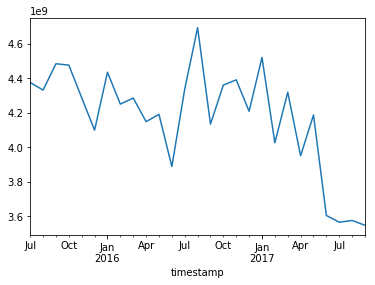

In [229]:
d['views'].plot()

In [34]:
j = get_page_access_data(endpoint_pagecounts, 'mobile-site', user_agent)
j

{'items': [{'access-site': 'mobile-site',
   'count': 3091546685,
   'granularity': 'monthly',
   'project': 'en.wikipedia',
   'timestamp': '2014100100'},
  {'access-site': 'mobile-site',
   'count': 3027489668,
   'granularity': 'monthly',
   'project': 'en.wikipedia',
   'timestamp': '2014110100'},
  {'access-site': 'mobile-site',
   'count': 3278950021,
   'granularity': 'monthly',
   'project': 'en.wikipedia',
   'timestamp': '2014120100'},
  {'access-site': 'mobile-site',
   'count': 3485302091,
   'granularity': 'monthly',
   'project': 'en.wikipedia',
   'timestamp': '2015010100'},
  {'access-site': 'mobile-site',
   'count': 3091534479,
   'granularity': 'monthly',
   'project': 'en.wikipedia',
   'timestamp': '2015020100'},
  {'access-site': 'mobile-site',
   'count': 3330832588,
   'granularity': 'monthly',
   'project': 'en.wikipedia',
   'timestamp': '2015030100'},
  {'access-site': 'mobile-site',
   'count': 3222089917,
   'granularity': 'monthly',
   'project': 'en.wikip

In [36]:
j = get_page_access_data(endpoint_pageviews, 'desktop', user_agent)
j

{'items': [{'access': 'desktop',
   'agent': 'user',
   'granularity': 'monthly',
   'project': 'en.wikipedia',
   'timestamp': '2015070100',
   'views': 4376666686},
  {'access': 'desktop',
   'agent': 'user',
   'granularity': 'monthly',
   'project': 'en.wikipedia',
   'timestamp': '2015080100',
   'views': 4332482183},
  {'access': 'desktop',
   'agent': 'user',
   'granularity': 'monthly',
   'project': 'en.wikipedia',
   'timestamp': '2015090100',
   'views': 4485491704},
  {'access': 'desktop',
   'agent': 'user',
   'granularity': 'monthly',
   'project': 'en.wikipedia',
   'timestamp': '2015100100',
   'views': 4477532755},
  {'access': 'desktop',
   'agent': 'user',
   'granularity': 'monthly',
   'project': 'en.wikipedia',
   'timestamp': '2015110100',
   'views': 4287720220},
  {'access': 'desktop',
   'agent': 'user',
   'granularity': 'monthly',
   'project': 'en.wikipedia',
   'timestamp': '2015120100',
   'views': 4100012037},
  {'access': 'desktop',
   'agent': 'user',

In [38]:
j = get_page_access_data(endpoint_pageviews, 'mobile-app', user_agent)
j

{'items': [{'access': 'mobile-app',
   'agent': 'user',
   'granularity': 'monthly',
   'project': 'en.wikipedia',
   'timestamp': '2015070100',
   'views': 109624146},
  {'access': 'mobile-app',
   'agent': 'user',
   'granularity': 'monthly',
   'project': 'en.wikipedia',
   'timestamp': '2015080100',
   'views': 109669149},
  {'access': 'mobile-app',
   'agent': 'user',
   'granularity': 'monthly',
   'project': 'en.wikipedia',
   'timestamp': '2015090100',
   'views': 96221684},
  {'access': 'mobile-app',
   'agent': 'user',
   'granularity': 'monthly',
   'project': 'en.wikipedia',
   'timestamp': '2015100100',
   'views': 94523777},
  {'access': 'mobile-app',
   'agent': 'user',
   'granularity': 'monthly',
   'project': 'en.wikipedia',
   'timestamp': '2015110100',
   'views': 94353925},
  {'access': 'mobile-app',
   'agent': 'user',
   'granularity': 'monthly',
   'project': 'en.wikipedia',
   'timestamp': '2015120100',
   'views': 99438956},
  {'access': 'mobile-app',
   'agen

In [39]:
j = get_page_access_data(endpoint_pageviews, 'mobile-app', user_agent)
j

{'items': [{'access': 'mobile-app',
   'agent': 'user',
   'granularity': 'monthly',
   'project': 'en.wikipedia',
   'timestamp': '2015070100',
   'views': 109624146},
  {'access': 'mobile-app',
   'agent': 'user',
   'granularity': 'monthly',
   'project': 'en.wikipedia',
   'timestamp': '2015080100',
   'views': 109669149},
  {'access': 'mobile-app',
   'agent': 'user',
   'granularity': 'monthly',
   'project': 'en.wikipedia',
   'timestamp': '2015090100',
   'views': 96221684},
  {'access': 'mobile-app',
   'agent': 'user',
   'granularity': 'monthly',
   'project': 'en.wikipedia',
   'timestamp': '2015100100',
   'views': 94523777},
  {'access': 'mobile-app',
   'agent': 'user',
   'granularity': 'monthly',
   'project': 'en.wikipedia',
   'timestamp': '2015110100',
   'views': 94353925},
  {'access': 'mobile-app',
   'agent': 'user',
   'granularity': 'monthly',
   'project': 'en.wikipedia',
   'timestamp': '2015120100',
   'views': 99438956},
  {'access': 'mobile-app',
   'agen

In [13]:
#baz = {'foo':'bar'}
'{foo}'.format(**{'foo':'bar'})

'bar'

In [16]:
{'User-Agent':'{foo}'.format(**{'foo':'bar'})}

{'User-Agent': 'bar'}

In [19]:
{'User-Agent':'{user_agent}'.format(**{'user_agent':user_agent})}

{'User-Agent': 'https://github.com/aenfield'}

In [28]:
{'User-Agent':'{}'.format(user_agent)}

{'User-Agent': 'https://github.com/aenfield'}